# MaxEnt

In [1]:
import time
import math
import numpy as np

import sys
sys.path.append("../../environments/MDPGridWorld/")
from MDPGridWorld import *
from maxent_irl import *
from plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
def terminal_state_potential_fn(s_idx, terminal_state_idx):
    
    if s_idx == terminal_state_idx:
        return 0
    else:
        return -1e20

In [3]:
def run_max_ent_gridworld_experiment(grid,
                                     n_traj, 
                                     max_traj_len, 
                                     n_epochs,
                                     learning_rate,
                                     action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=False,
                                     gamma=0.99,
                                     verbose=False,
                                     epoch_summary_rate=None):
    
    gw = MDPGridWorld(grid, living_reward, gamma, action_noise_dist, obstacle_reward, visit_obstacles, verbose=verbose)
    phi=lambda x: terminal_state_potential_fn(x, gw.absorbing_state_idx)
    trajectories = np.asarray(gw.sample_trajectories(n_traj, init_state_idx=init_state_idx, 
                                                     max_length=max_traj_len, visit_obstacles_as_init=visit_obstacles), dtype=np.int)
    start = time.time()
    if linear_features:
        feature_matrix = gw.get_state_grid_features_matrix()
    else:
        feature_matrix = gw.get_state_2d_features_matrix()
        
    R = max_ent_irl(trajectories, feature_matrix, 
                    gw.gamma, gw.nA, gw.T, 
                    n_epochs, learning_rate, 
                    phi, vi_eps=vi_eps, epoch_summary_rate=epoch_summary_rate)
    print("Total Time: {} sec".format(time.time()-start))
    return R, gw, trajectories, feature_matrix

In [4]:
def plot_results(gw, grid, R, n_epochs, learning_rate):

    plt.figure(figsize=(14,8))
    print("Expert Policy")
    gw.disp_custom_grid(gw.vi_results.policy, lambda x: "{:}".format(gw.actions_name[x]))
    vi_recovered = run_value_iteration(gw.T, R, gw.gamma)
    print("Recovered Policy")
    gw.disp_custom_grid(vi_recovered.policy, lambda x: "{:}".format(gw.actions_name[x]))
    compare_grid_data(gw.vi_results.policy, vi_recovered.policy, gw.height, gw.width, 
                      suffix="policy:", 
                      grid=grid, plots=[(2,2,1), (2,2,2)])
    
    print("Groundtruth R")
    gw.disp_custom_grid(gw.R, formatting=lambda x: "{:.3f}".format(x))
    print("Recovered R")
    gw.disp_custom_grid(R, formatting=lambda x: "{:.3f}".format(x))
    
    compare_grid_data(gw.R, R, gw.height, gw.width, suffix="reward ", 
                      title2="MaxEnt inferred. \nIter={}, lr={}".format(n_epochs, learning_rate), 
                      grid=grid, plots=[(2,2,3), (2,2,4)])

## Determinitic Dynamics & Linear Rewards (True R = w.dot(fs))

In [5]:
action_noise_dist = [0., 1., 0.]

### Simple Grid

 Epoch 5, sum|grad|: 2.824489451085287
 Epoch 10, sum|grad|: 1.1071259796135695
 Epoch 15, sum|grad|: 0.671388994576068
 Epoch 20, sum|grad|: 0.5553902174097594
Total Time: 11.153404235839844 sec
Expert Policy
---------------
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Recovered Policy
---------------
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Groundtruth R
---------------
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	1.000	
Absorbing state: 0.000
---------------

Recovered R
---------------
-0.858	-0.971	-0.965	-0.902	-0.887	
-0.847	-1.181	-1.238	-1.903	-0.580	
-1.096	-1.234	-1.649	-2.279	-1.359	
-0.966

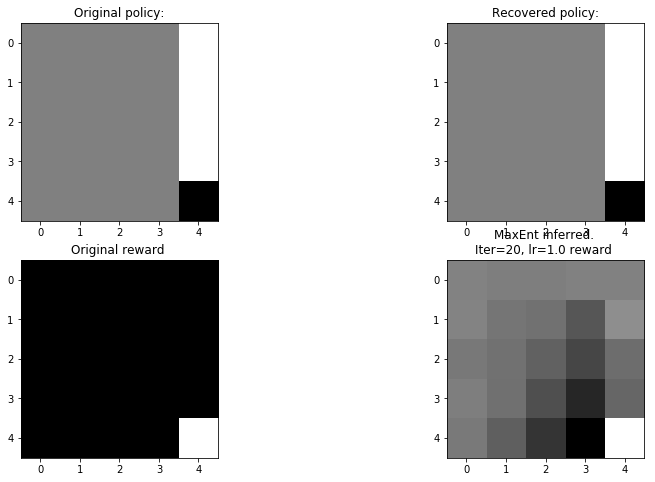

In [6]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',+1]]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 100, 20
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=True,
                                     gamma=0.99,
                                     epoch_summary_rate=5)
plot_results(gw, grid, R, n_epochs, lr)

### Grid with obstacles
Let's not visit obstacle states and see

 Epoch 10, sum|grad|: 0.8057639028011849
 Epoch 20, sum|grad|: 0.5263006962597606
Total Time: 11.2117280960083 sec
Expert Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
East	South	East	East	South	
East	East	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Recovered Policy
---------------
East	East	East	East	South	
South	South	East	East	South	
East	South	South	East	South	
East	East	South	South	South	
East	East	East	East	North	
Absorbing state: North
---------------

Groundtruth R
---------------
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.500	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.500	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.500	-0.040	
-0.040	-0.040	-0.040	-0.040	1.000	
Absorbing state: 0.000
---------------

Recovered R
---------------
-1.282	-0.748	-0.649	-0.539	-0.402	
-1.463	0.200	-1.136	-1.806	-0.440	
-1.565	-1.505	0.927	-1.745	-1.678	
-2.157	-0.571	-0.553	0.987	-2.719	
-0.993	-2.090	-1.180	-1.653	1.519	
Absorbing 

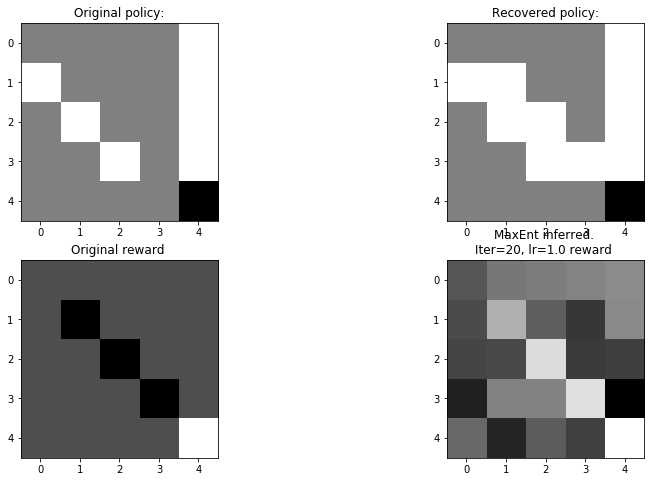

In [7]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
        [' ','#',' ',' ',' '],
        [' ',' ','#',' ',' '],
        [' ',' ',' ','#',' '],
        [' ',' ',' ',' ',+1]]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 100, 20
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=False, #Note!
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

The policy hasn't converged yet, let's run it longer till 50th epoch.

 Epoch 10, sum|grad|: 0.8057639028011849
 Epoch 20, sum|grad|: 0.5263006962597606
 Epoch 30, sum|grad|: 0.40034624330537916
 Epoch 40, sum|grad|: 0.33220245750803534
 Epoch 50, sum|grad|: 0.2898774827169851
Total Time: 28.527328968048096 sec
Expert Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
East	South	East	East	South	
East	East	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Recovered Policy
---------------
East	East	East	East	South	
South	South	East	East	South	
East	South	South	East	South	
East	East	South	South	South	
East	East	East	East	North	
Absorbing state: North
---------------

Groundtruth R
---------------
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.500	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.500	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.500	-0.040	
-0.040	-0.040	-0.040	-0.040	1.000	
Absorbing state: 0.000
---------------

Recovered R
---------------
-1.491	-1.034	-1.052	-0.992	-0.902	
-1.915	0.200	-1.725	-3.

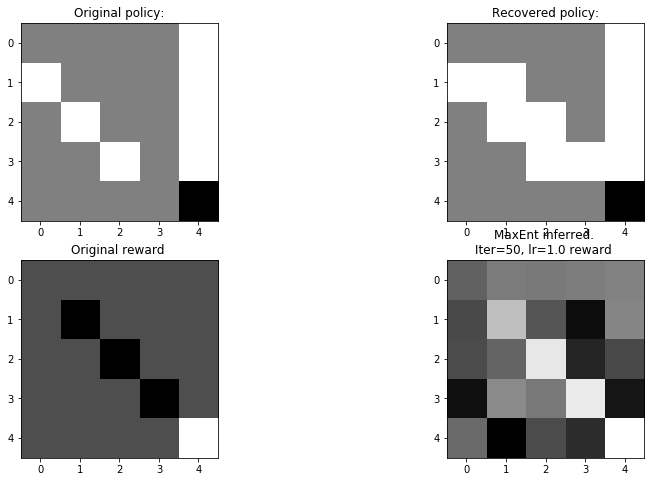

In [8]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
        [' ','#',' ',' ',' '],
        [' ',' ','#',' ',' '],
        [' ',' ',' ','#',' '],
        [' ',' ',' ',' ',+1]]
n_epochs, lr = 50, 1.
n_traj, max_traj_len = 100, 20
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=False, #Note!
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

We fail to converge to a good policy. Let's try visiting obstacle states.

 Epoch 10, sum|grad|: 0.9055311199939998
 Epoch 20, sum|grad|: 0.5350727155997281
 Epoch 30, sum|grad|: 0.43987354134687523
Total Time: 16.26250696182251 sec
Expert Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
East	South	East	East	South	
East	East	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Recovered Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
East	South	East	East	South	
East	East	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Groundtruth R
---------------
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.500	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.500	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.500	-0.040	
-0.040	-0.040	-0.040	-0.040	1.000	
Absorbing state: 0.000
---------------

Recovered R
---------------
-1.003	-1.016	-1.054	-0.932	-1.007	
-1.069	-1.781	-1.298	-2.303	-0.772	
-0.864	-1.210	-2.506	-2.604	-1.294	
-1.415	-0.727	-1.334	-4.503	-1.922	
-1

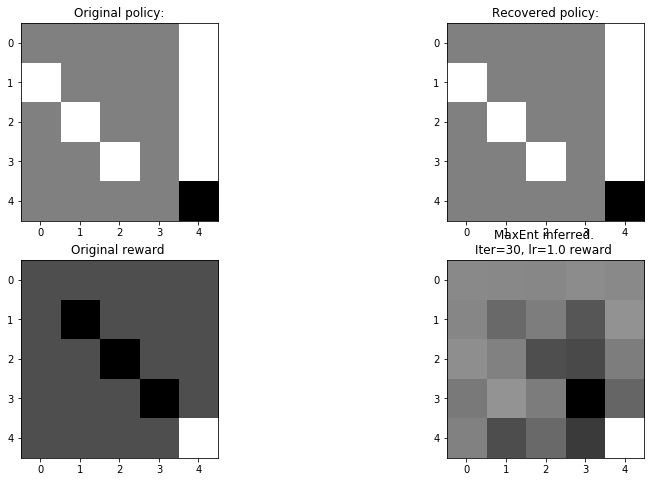

In [9]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
        [' ','#',' ',' ',' '],
        [' ',' ','#',' ',' '],
        [' ',' ',' ','#',' '],
        [' ',' ',' ',' ',+1]]
n_epochs, lr = 30, 1.
n_traj, max_traj_len = 100, 20
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=True,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

We can see that this helps in learning/recovering better policies and reward function.

Now, let's try increasing obstacle penalties to see how it affects our results.

 Epoch 10, sum|grad|: 0.9055311199939998
 Epoch 20, sum|grad|: 0.5350727155997281
 Epoch 30, sum|grad|: 0.43987354134687523
Total Time: 16.589802980422974 sec
Expert Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
East	South	East	East	South	
East	East	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Recovered Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
East	South	East	East	South	
East	East	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Groundtruth R
---------------
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-5.000	-0.040	-0.040	-0.040	
-0.040	-0.040	-5.000	-0.040	-0.040	
-0.040	-0.040	-0.040	-5.000	-0.040	
-0.040	-0.040	-0.040	-0.040	1.000	
Absorbing state: 0.000
---------------

Recovered R
---------------
-1.003	-1.016	-1.054	-0.932	-1.007	
-1.069	-1.781	-1.298	-2.303	-0.772	
-0.864	-1.210	-2.506	-2.604	-1.294	
-1.415	-0.727	-1.334	-4.503	-1.922	
-

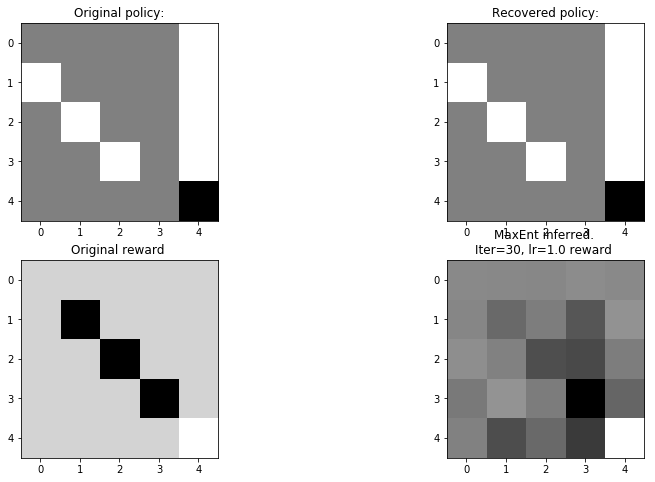

In [10]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
        [' ','#',' ',' ',' '],
        [' ',' ','#',' ',' '],
        [' ',' ',' ','#',' '],
        [' ',' ',' ',' ',+1]]
n_epochs, lr = 30, 1.
n_traj, max_traj_len = 100, 20
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-5,
                                     visit_obstacles=True,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

We converge to almost identical R and Pi. There's no significant improvement by penalizing obstacle visits beyond certain limit.

### R&N Chap. 17 Grid World

Not visiting obstacles

 Epoch 10, sum|grad|: 0.5239588910126985
 Epoch 20, sum|grad|: 0.30251810830575493
Total Time: 5.541101694107056 sec
Expert Policy
------------
East	East	East	North	
North	North	North	North	
North	East	North	West	
Absorbing state: North
------------

Recovered Policy
------------
East	East	East	North	
North	East	North	North	
North	East	North	West	
Absorbing state: North
------------

Groundtruth R
------------
-0.040	-0.040	-0.040	1.000	
-0.040	-0.500	-0.040	-1.000	
-0.040	-0.040	-0.040	-0.040	
Absorbing state: 0.000
------------

Recovered R
------------
-1.232	-1.557	-0.733	3.581	
-1.026	0.817	-0.504	-2.560	
-1.933	-3.706	-0.640	-1.151	
Absorbing state: 0.225
------------



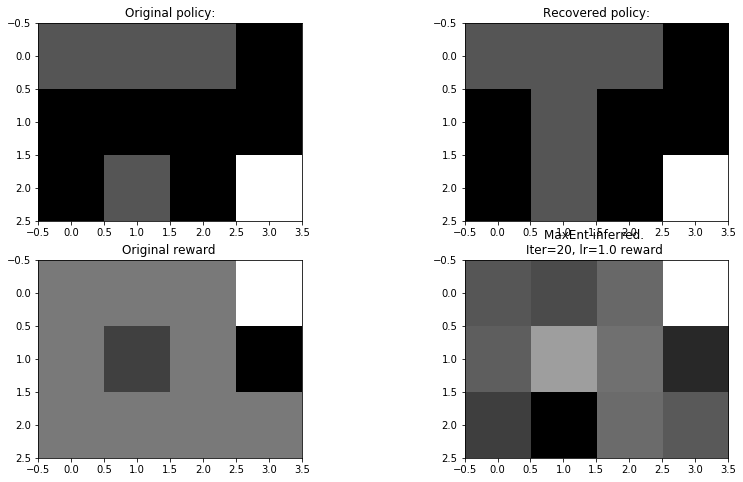

In [11]:
np.random.seed(0)
grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 400, 15
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=False,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

Visiting obstacles

 Epoch 10, sum|grad|: 0.513622637757714
 Epoch 20, sum|grad|: 0.3188646727150539
Total Time: 5.567760944366455 sec
Expert Policy
------------
East	East	East	North	
North	North	North	North	
North	East	North	West	
Absorbing state: North
------------

Recovered Policy
------------
East	East	East	North	
North	North	North	North	
North	East	North	West	
Absorbing state: North
------------

Groundtruth R
------------
-0.040	-0.040	-0.040	1.000	
-0.040	-0.500	-0.040	-1.000	
-0.040	-0.040	-0.040	-0.040	
Absorbing state: 0.000
------------

Recovered R
------------
-0.807	-0.621	-0.910	4.095	
-0.787	-2.509	-0.758	-1.993	
-1.396	-2.101	-0.397	-1.250	
Absorbing state: 0.134
------------



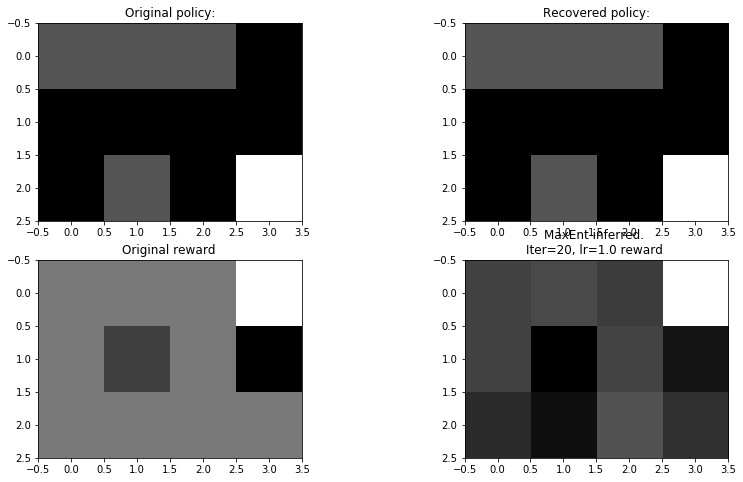

In [12]:
np.random.seed(0)
grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 400, 15
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=True,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

## Stochastic Dynamics & Linear Rewards (True R = w.dot(fs))

In [13]:
action_noise_dist = [0.1, 0.8, 0.1]

### Simple Grid

 Epoch 10, sum|grad|: 0.9689988928866444
 Epoch 20, sum|grad|: 0.597825321262178
Total Time: 12.833080053329468 sec
Expert Policy
---------------
East	East	East	South	South	
South	South	South	South	South	
South	East	East	South	South	
East	East	East	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Recovered Policy
---------------
East	East	East	South	West	
South	South	South	South	South	
East	East	East	South	South	
East	East	East	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Groundtruth R
---------------
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.040	1.000	
Absorbing state: 0.000
---------------

Recovered R
---------------
-1.254	-0.948	-0.875	-0.619	-3.285	
-1.592	-2.134	-2.670	-1.979	-2.901	
-0.728	-1.647	-1.714	0.730	-2.639	
-0.326	-1.286	-1.813	0.143	-0.370	
-1.372	-1.197	-1.652	-2.757	1.438	
Absor

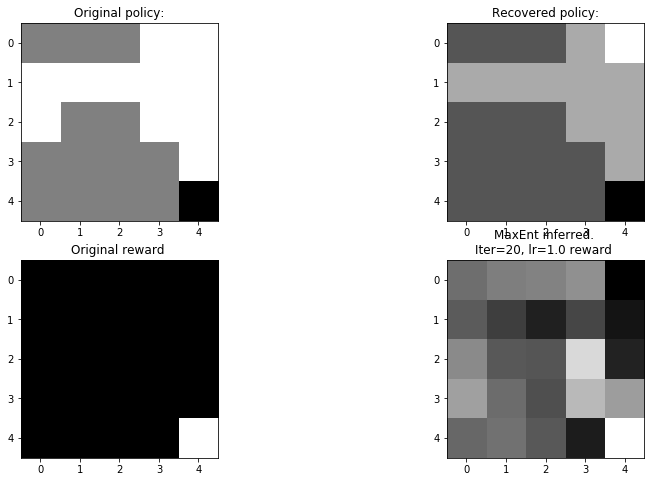

In [14]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',' '],
                [' ',' ',' ',' ',+1]]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 1000, 40
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=True,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

### Grid with obstacles

 Epoch 10, sum|grad|: 1.1692485551984821
 Epoch 20, sum|grad|: 0.8051943634997062
Total Time: 12.946033954620361 sec
Expert Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
South	South	East	East	South	
South	South	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Recovered Policy
---------------
East	East	East	East	South	
South	East	East	East	South	
South	South	East	East	South	
South	South	South	East	South	
East	East	East	East	North	
Absorbing state: North
---------------

Groundtruth R
---------------
-0.040	-0.040	-0.040	-0.040	-0.040	
-0.040	-0.500	-0.040	-0.040	-0.040	
-0.040	-0.040	-0.500	-0.040	-0.040	
-0.040	-0.040	-0.040	-0.500	-0.040	
-0.040	-0.040	-0.040	-0.040	1.000	
Absorbing state: 0.000
---------------

Recovered R
---------------
-0.509	-0.196	-0.621	0.095	-0.053	
-0.708	-1.005	-0.537	-1.169	-0.079	
-0.062	-1.379	-1.765	-1.609	-0.182	
-0.742	-1.154	-2.199	-2.468	-0.414	
-0.269	0.237	-0.119	-1.499	-0.055	
Abs

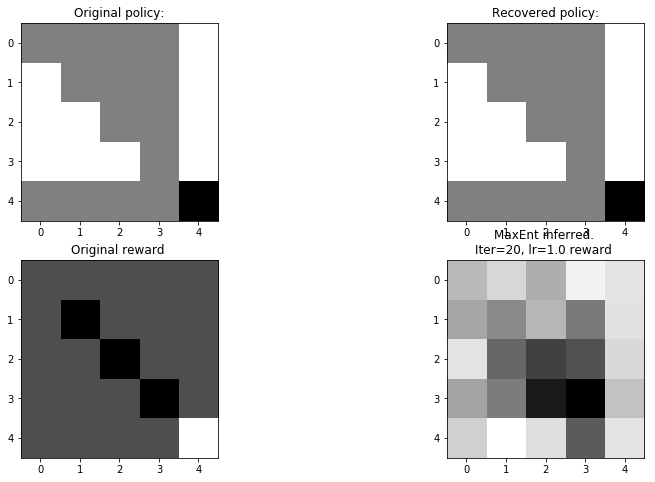

In [15]:
np.random.seed(0)
grid = [[' ',' ',' ',' ',' '],
                [' ','#',' ',' ',' '],
                [' ',' ','#',' ',' '],
                [' ',' ',' ','#',' '],
                [' ',' ',' ',' ',+1]]
n_epochs, lr = 20, 1.
n_traj, max_traj_len = 400, 40
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-3,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=True,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

### R&N Chap. 17 Grid World

Not visiting obstacles

 Epoch 10, sum|grad|: 1.277391554716635
 Epoch 20, sum|grad|: 0.6430632595844115
 Epoch 30, sum|grad|: 0.3243846414795075
 Epoch 40, sum|grad|: 0.24127777386415378
Total Time: 20.74955701828003 sec
Expert Policy
------------
East	East	East	North	
North	North	North	North	
North	West	North	West	
Absorbing state: North
------------

Recovered Policy
------------
East	East	East	North	
North	North	North	North	
North	West	North	West	
Absorbing state: North
------------

Groundtruth R
------------
-0.040	-0.040	-0.040	1.000	
-0.040	-1.000	-0.040	-1.000	
-0.040	-0.040	-0.040	-0.040	
Absorbing state: 0.000
------------

Recovered R
------------
-0.967	-1.089	-0.651	6.483	
-0.528	0.067	-1.554	-4.352	
-0.369	-2.565	-2.615	-2.146	
Absorbing state: 0.132
------------



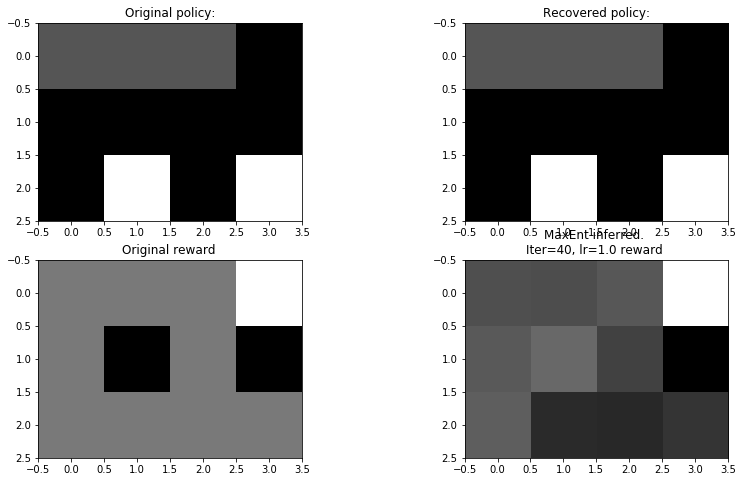

In [16]:
np.random.seed(0)
grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]
n_epochs, lr = 40, 1.
n_traj, max_traj_len = 1200, 30
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-1, 
                                     visit_obstacles=False,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)

Visit obstacles

 Epoch 10, sum|grad|: 1.0165781503469218
 Epoch 20, sum|grad|: 0.4945683533256543
 Epoch 30, sum|grad|: 0.28569810407164126
 Epoch 40, sum|grad|: 0.21855069113571984
Total Time: 21.238718271255493 sec
Expert Policy
------------
East	East	East	North	
North	North	North	North	
North	West	North	West	
Absorbing state: North
------------

Recovered Policy
------------
East	East	East	North	
North	North	North	North	
North	West	North	West	
Absorbing state: North
------------

Groundtruth R
------------
-0.040	-0.040	-0.040	1.000	
-0.040	-0.500	-0.040	-1.000	
-0.040	-0.040	-0.040	-0.040	
Absorbing state: 0.000
------------

Recovered R
------------
-0.471	-0.036	-0.545	6.023	
0.241	-3.521	-1.341	-4.300	
-0.006	-2.200	-0.535	-1.884	
Absorbing state: 0.422
------------



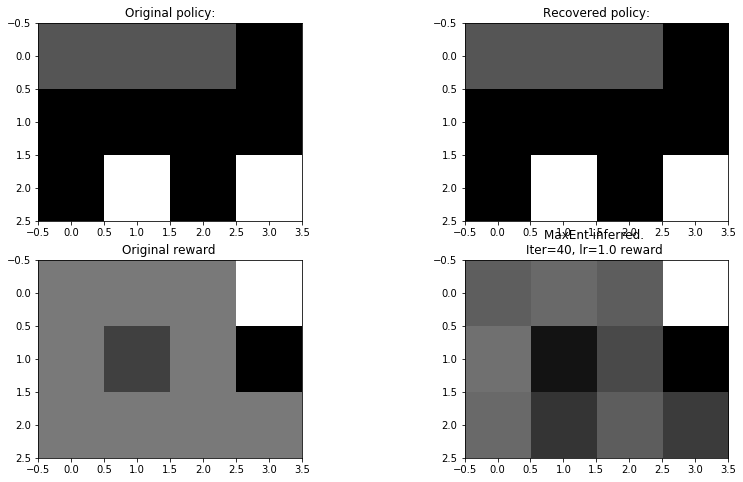

In [17]:
np.random.seed(0)
grid = [[' ',' ',' ',+1],
            [' ','#',' ',-1],
            ['@',' ',' ',' ']]
n_epochs, lr = 40, 1.
n_traj, max_traj_len = 1200, 30
R, gw, trajectories, feature_matrix = \
                    run_max_ent_gridworld_experiment(grid,
                                     n_traj=n_traj, 
                                     max_traj_len=max_traj_len, 
                                     n_epochs=n_epochs,
                                     learning_rate=lr,
                                     action_noise_dist=action_noise_dist,
                                     terminal_state_potential_fn=terminal_state_potential_fn,
                                     linear_features=True,
                                     init_state_idx="random",
                                     vi_eps=1e-6,
                                     living_reward=-0.04, 
                                     obstacle_reward=-0.5, 
                                     visit_obstacles=True,
                                     gamma=0.99,
                                     epoch_summary_rate=10)
plot_results(gw, grid, R, n_epochs, lr)